# RGI04 (Arctic Canada South)

F. Maussion

Full replace by Philipp and Frank, except Labrador which still used RGI6

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import (mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, 
                   find_duplicates, open_zip_shapefile, correct_geoms, fix_overaps)
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 4

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '04_rgi60_ArcticCanadaNorth.zip')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, _ = submission_summary(shp)
sdf

N        A                                           analysts  \
subm_id                                                                      
589       7408  40784.7  Barrand, Burgess, Cawkwell, Copland, Filbert, ...   
745          7    103.6  Barrand, Burgess, Cawkwell, Copland, Filbert, ...   
817      10908  40518.3                            Mabileau, Paul, Rastner   

        submitters  release_date  \
subm_id                            
589          Bolch          2015   
745          Bolch          2021   
817           Paul          2023   

                                                 geog_area  src_date_mode  \
subm_id                                                                     
589      Randolph Glacier Inventory; Umbrella RC for me...           2000   
745      Randolph Glacier Inventory; Umbrella RC for me...           2002   
817                                  Various (GlobGlacier)           2000   

         src_date_min  src_date_max  
subm_id                              
589              1958          2010  
745              2002          2002  
817              1999          2002

Notes based on individual submission evaluations: 

- 589: This is the RGI6
- 745: also RGI6, corrected: for https://github.com/GLIMS-RGI/rgi7_scripts/issues/8
- 817: this is the new submission by F&P - valid above 61°N, below we need RGI6: https://github.com/GLIMS-RGI/rgi7_scripts/issues/57

In [5]:
# # Write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

### Apply selection criteria to create the RGI7 data subset

In [6]:
rgi7_north = shp.loc[shp['subm_id'].isin([817])].copy()
print(needs_size_filter(rgi7_north))
rgi7_north['is_rgi6'] = False

True


In [7]:
rgi7_south = shp.loc[shp['subm_id'].isin([589, 745])].copy()
rgi7_south = rgi7_south.loc[rgi7_south.CenLat < 61]
print(needs_size_filter(rgi7_south))
rgi7_south['is_rgi6'] = True

False


In [8]:
# combine the geodataframes
rgi7 = pd.concat([rgi7_north, rgi7_south])

In [9]:
# This is a not a glacier
len_bef = len(rgi7)
rgi7 = rgi7.loc[rgi7.anlys_id != 1026558].copy()  # G295813E65111N
assert len(rgi7) == (len_bef - 1)

### Some sanity checks 

In [10]:
dupes = find_duplicates(rgi7)

Seems Okay!


In [11]:
rgi7 = correct_geoms(rgi7)

Found 83 invalid geometries out of 11010.
After correction, 0 geometries are still invalid.
Area changed by -0.2 m2 (-0.0000%, or 0 tiny glaciers)


In [12]:
rgi7 = fix_overaps(rgi7)

Finding intersecting geometries
Computing overlap of intersecting pairs
Found 16 overlaps out of 11010. Correcting...
After correction, Area changed by -27.8 m2 (-0.0000%, or 0 tiny glaciers)
Final check...
Finding intersecting geometries
Computing overlap of intersecting pairs
OK! Check done


In [13]:
rgi7 = correct_geoms(rgi7)

Found 0 invalid geometries out of 11010.


In [14]:
print(len(rgi7))
rgi7 = size_filter(rgi7)
print(len(rgi7))

11010
11009


In [15]:
sdf, df_class = submission_summary(rgi7)
df_class

N   N NA
subm_id              
817      10906  10906
589        103    103

In [16]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    if np.any(np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())):
        print('Orphan rock outcrops detected.')

### Plots 

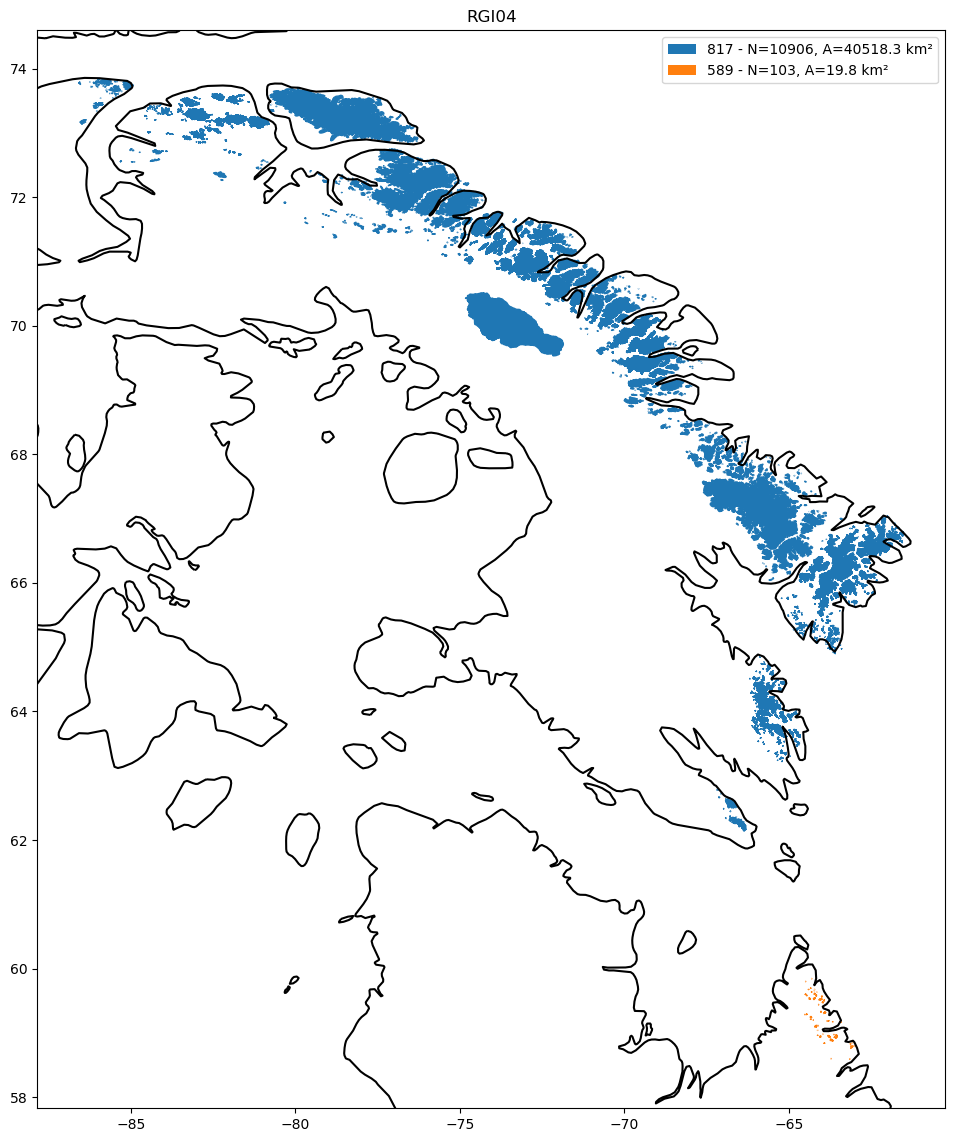

In [17]:
plot_map(rgi7, reg)

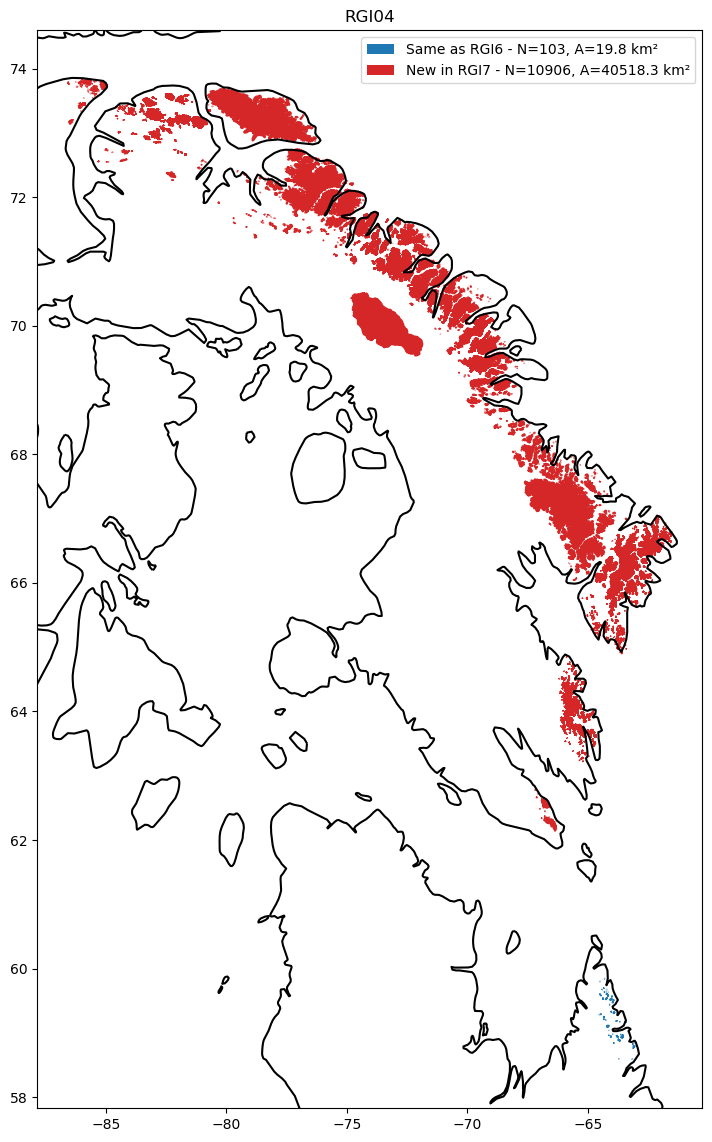

In [18]:
plot_map(rgi7, reg, is_rgi6=True)

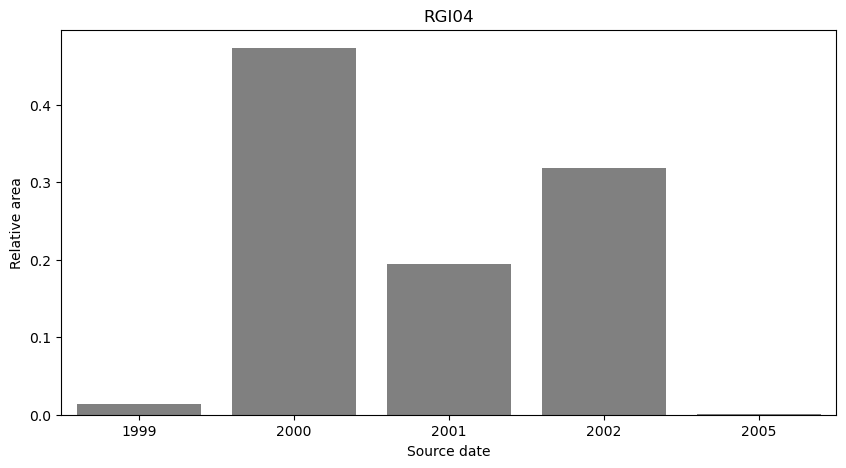

In [19]:
plot_date_hist(rgi7, reg)

### Text for github

In [20]:
fgh = sdf.T
fgh

subm_id                            817  \
N                                10906   
A                              40518.3   
analysts       Mabileau, Paul, Rastner   
submitters                        Paul   
release_date                      2023   
geog_area        Various (GlobGlacier)   
src_date_mode                     2000   
src_date_min                      1999   
src_date_max                      2002   

subm_id                                                      589  
N                                                            103  
A                                                           19.8  
analysts       Barrand, Burgess, Cawkwell, Copland, Filbert, ...  
submitters                                                 Bolch  
release_date                                                2015  
geog_area      Randolph Glacier Inventory; Umbrella RC for me...  
src_date_mode                                               2005  
src_date_min                                                2005  
src_date_max                                                2005

In [21]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 817                     | 589                                                                                                     |
|:--------------|:------------------------|:--------------------------------------------------------------------------------------------------------|
| N             | 10906                   | 103                                                                                                     |
| A             | 40518.3                 | 19.8                                                                                                    |
| analysts      | Mabileau, Paul, Rastner | Barrand, Burgess, Cawkwell, Copland, Filbert, Gardner, Hartmann, OCallaghan, Paul, Sharp, Wolken, Wyatt |
| submitters    | Paul                    | Bolch                                                                                                   |
| release_date  | 2023                    | 2015                                                    

## Write out and tar 

In [22]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI04/
RGI04/RGI04.cpg
RGI04/RGI04.prj
RGI04/RGI04.shx
RGI04/RGI04.dbf
RGI04/RGI04.shp
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI04.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI04'], returncode=0)


In [23]:
print('Done!')

Done!


## Consistency checks

### With RGI6 (South) 

In [ ]:
from utils import open_zip_shapefile
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [ ]:
rgi6 = rgi6.loc[rgi6.CenLat < 61]

In [ ]:
len(rgi7_south), len(rgi6)

Test the areas:

In [ ]:
rgi6['Area_us'] = rgi6.to_crs({'proj':'cea'}).area 
rgi7_south['area'] = rgi7.to_crs({'proj':'cea'}).area 

In [ ]:
print('Area RGI7a (km2)', rgi7_south['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['Area'].sum())
print('Area RGI6 computed by us (km2)', rgi6['Area_us'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (km2)', (rgi6['Area_us'].sum() - rgi7_south['area'].sum()) * 1e-6)

### With F&P submission 

In [ ]:
ref_pr = open_zip_shapefile(data_dir + '/l0_support_data/c3s_gi_rgi04_L7_2000_v1.zip')
ref_pr['area'] = ref_pr.to_crs({'proj':'cea'}).area 

In [ ]:
print('Number of glaciers in RGI7 subset:', len(rgi7_north))
print('Number of glaciers in reference data (FP):', len(ref_pr))
print('Difference:', len(rgi7_north)-len(ref_pr))

In [ ]:
print('Area RGI7a (km2)', rgi7_north['area'].sum() * 1e-6)
print('Area Ref (km2)', ref_pr['area'].sum())
print('diff areas Ref - RGI7 (km2)', (ref_pr['area'].sum() - rgi7_north['area'].sum()) * 1e-6)

### With RGI6 (Full: differences do not depict problems, just differences) 

In [ ]:
rgi6 = open_zip_shapefile(rgi6_reg_file)

In [ ]:
len(rgi7), len(rgi6)

Test the areas:

In [ ]:
rgi6['Area_us'] = rgi6.to_crs({'proj':'cea'}).area 
rgi7['area'] = rgi7.to_crs({'proj':'cea'}).area 

In [ ]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['Area'].sum())
print('Area RGI6 computed by us (km2)', rgi6['Area_us'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (km2)', (rgi6['Area_us'].sum() - rgi7['area'].sum()) * 1e-6)